In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from scipy import optimize
%matplotlib inline

dtype('uint8')

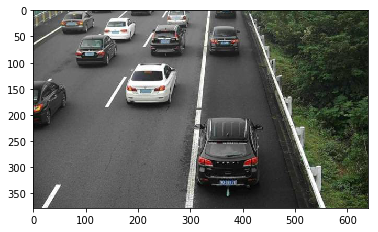

In [2]:
image = mpimg.imread('goodimg.jpg')
plt.imshow(image)
image.dtype
# img = np.array(image, dtype=np.uint8)

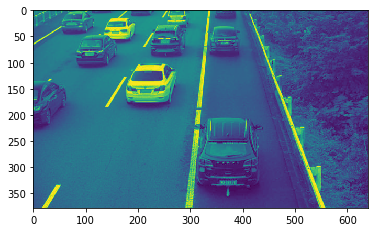

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = grayscale(image)
plt.imshow(gray)

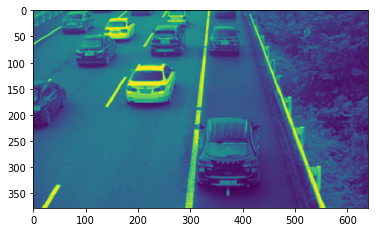

In [4]:
kernel_size=5
def gaussion_blur(gray, kernel_size):
    return cv2.GaussianBlur(gray, (kernel_size, kernel_size),0)
gaussion = gaussion_blur(gray,kernel_size)
plt.imshow(gaussion)

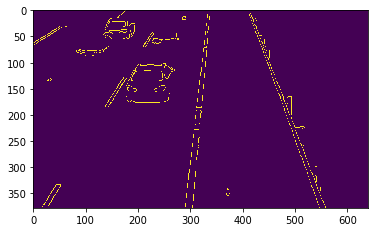

In [5]:
def canny(img, low_threshold,high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
canny = canny(gaussion,140,430)
plt.imshow(canny)

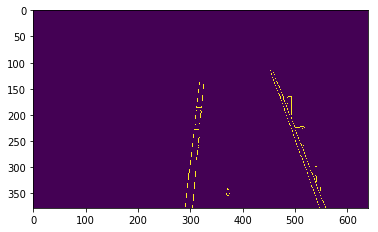

In [28]:
def region_of_interest(img,vertices):
    '''
    Apply an image mask

    '''
    #define a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else: 
        ignore_mask_color = 255#涂黑

    cv2.fillPoly(mask,vertices,ignore_mask_color)

    masked_image = cv2.bitwise_and(img,mask)#与操作
    return masked_image 
##区域的选取
#vertices = np.array([[(0, canny.shape[0]), (275, 250), (350, 450), (canny.shape[1], canny.shape[0])]])
vertices = np.array([[(30,canny.shape[0]),(230, 200), (400, 80), (860,canny.shape[0])]], dtype=np.int32)
roi = region_of_interest(canny,vertices)
plt.imshow(roi)

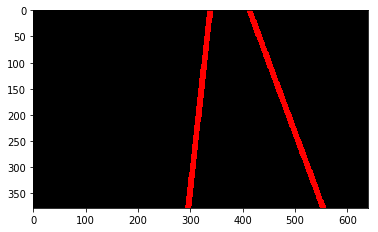

In [66]:
# Hough transform parameters
rho = 2
theta = np.pi / 180
threshold = 19
min_line_length = 60
max_line_gap = 30

def linear_fit(x, a, b):
    return a * x + b

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    right_x,right_y,left_x,left_y=[],[],[],[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1))<0:
                "right_line"
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            elif ((y2-y1)/(x2-x1))>0:
                "left_line"
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
                
    right_a, right_b = optimize.curve_fit(linear_fit, np.array(right_x), np.array(right_y))[0]
    right_x1 = int((img.shape[0] - right_b)/right_a)
    right_y1 = img.shape[0]
    right_x2 = int((0 - right_b)/right_a)
    right_y2 = 0
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    
    left_a, left_b = optimize.curve_fit(linear_fit, np.array(left_x), np.array(left_y))[0]
    left_x1 = int((img.shape[0] - left_b)/left_a)
    left_y1 = img.shape[0]
    left_x2 = int((0 - left_b)/left_a)
    left_y2 = 0
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, 
                min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                          minLineLength=min_line_len, 
                          maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


line_img = hough_lines(roi, rho, theta, threshold, 
                       min_line_length, max_line_gap)
plt.imshow(line_img)



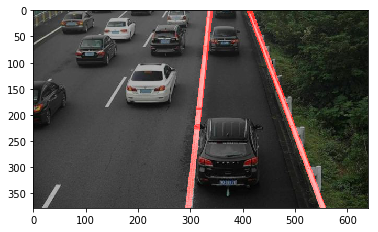

In [67]:
def weighted_img(img, initial_img, α=0.7, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(image, α, line_img, β, λ)
mix = weighted_img(line_img,image,α=0.7, β=1., λ=0.)
plt.imshow(mix)
